In [1]:
import warnings
warnings.filterwarnings("ignore")
import scanpy as sc
import graph_tool.all as gt
import schist
import pandas as pd
import anndata
import mygene
import pickle
import scipy.stats

%pylab
%matplotlib inline

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


# Analysis of cluster consistency for different datasets

Here we show how to perform analysis of cluster consistence given datasets that are known to have a different level of noise, all data profile PBMC + HEK293T cells for the Human Cell Atlas project

First we load some general annotations that have been downloaded from the paper supplementary data and refactored to be easy to load here.

In [2]:
markers = pd.read_excel('41587_2020_469_MOESM4_ESM.xlsx', skiprows=2)
cols = markers.columns
cols = [x.replace(' ', '_') for x in cols]
cols = [x.replace('+', '') for x in cols]
cols = [x.replace('-', '_') for x in cols]
cols = [x.replace('_cell', '') for x in cols]
markers.columns = cols

## Quartz-seq2 data

We download data and metadata directly from GEO archive

In [3]:
tdata = pd.read_table("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE133543&format=file&file=GSE133543%5FQUARTZseq%5Fhuman%5Fexp%5Fmat%2Etsv%2Egz", compression='gzip')
adata = anndata.AnnData(tdata.T)
metadata = pd.read_table("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE133543&format=file&file=GSE133543%5FQUARTZseq%5Fhuman%5Fmetada%2Etsv%2Egz", compression='gzip')

Annotate the dataset

In [4]:
hca_annot = pd.read_table("HCA_annotations.txt")
cells = [x for x in hca_annot.query('batch == "Quartz-Seq2"').index if x in adata.obs_names]

adata = adata[cells]

adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
sc.pp.filter_genes(adata, min_cells=5)

Trying to set attribute `.obs` of view, copying.


We here transform data in genesymbols, using MyGene as translator

In [5]:
mg = mygene.MyGeneInfo()

In [6]:
ensgenes = [x.split('.')[0] for x in adata.var_names]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-27990...done.
Finished.
2 input query terms found dup hits:
	[('ENSG00000002586', 2), ('ENSG00000229425', 2)]
167 input query terms found no hit:
	['ENSG00000116883', 'ENSG00000130723', 'ENSG00000154537', 'ENSG00000163009', 

In [7]:
nv = []
for e in adata.var_names:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
adata.var_names = nv
adata.var_names_make_unique()        

From the original Mereu et al. paper (we applied the very same filters):

For subsequent data analysis, we discarded cells with <10,000 total number of reads as well as the cells having <65% of the reads mapped to their reference genome. Cells in the 95th percentile of the number of genes/cell and those having <25% mitochondrial gene content were included in the downstream analyses. Genes that were expressed in less than five cells were removed.
For the comparative viability analysis, we used EmptyDrops17to determine the inflection point on the ranked barcodes vs number of detected UMIs for each library separately. We assigned all barcodes before the inflection point as cells and the remaining as empty drops.
Filtering, normalization, selection of highly variable genes (HVG), and clustering of cells were performed using the Seurat18 package (version 2.3.4). We normalized the gene expression measurements for each cell by the total expression, multiplied by a scale factor (10e4), and log- transformed the result. We used 10e4 (instead of 10e6 more commonly used in bulk RNA-seq) due to the reduced number of transcripts present in single-cell data. To avoid spurious correlations, the library sizes were regressed out, and the genes were scaled and centered. The scaled Z-score values were then used as normalized gene measurement input for clustering and for visualizing differences in expression between cell clusters. We selected HVGs by evaluating the relationship between gene dispersion (y.cutoff = 0.5) and the log mean expression. The clustering procedure projects cells onto a reduced dimensional space, and then groups them into subpopulations by computing a shared-nearest-neighbour (SNN) based on the Euclidean distance (finding highly interconnected communities). The algorithm is a variant of the Louvain method, which uses a resolution parameter to determine the number of clusters.

In [8]:
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.25, :]
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]

Trying to set attribute `.obs` of view, copying.


In [9]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2

Trying to set attribute `.obs` of view, copying.
... storing 'nnet2' as categorical


Here is the real processing, up to the `schist` inference. 

In [10]:
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [11]:
n_neighbors = int(np.sqrt(adata.shape[0])/2)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=n_neighbors)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:18)


In [12]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:03)


Here  clustering is performed with default parameters, except for degree gorrections and number of initiazlisations.

In [13]:
schist.inference.nested_model(adata, deg_corr=True, n_init=3, return_low=True,
                                 random_seed=42)

minimizing the nested Stochastic Block Model
    done (0:01:24)
    calculating cell affinity to groups
    finished (0:01:27)


In [14]:
schist.io.write(adata, prefix='Quartzseq')

## Chromium 10xv3 data

We repeat the very same steps as above, on a different dataset

In [15]:
tdata = pd.read_table("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE133535&format=file&file=GSE133535%5F10X2x5Kcell250Kreads%5Fhuman%5Fexp%5Fmat%2Etsv%2Egz", compression='gzip')
adata = anndata.AnnData(tdata.T)
metadata = pd.read_table("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE133535&format=file&file=GSE133535%5F10X2x5Kcell250Kreads%5Fhuman%5Fmetada%2Etsv%2Egz", compression='gzip')

In [16]:
#annotations
hca_annot = pd.read_table("HCA_annotations.txt")
cells = [x for x in hca_annot.query('batch == "Chromium"').index if x in adata.obs_names]
adata = adata[cells]
adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
#processing
mg = mygene.MyGeneInfo()
ensgenes = [x.split('.')[0] for x in adata.var_names]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)
nv = []
for e in adata.var_names:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
adata.var_names = nv
adata.var_names_make_unique()        
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.25, :]
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2
sc.tl.pca(adata)
n_neighbors = int(np.sqrt(adata.shape[0])/2)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=n_neighbors)
sc.tl.umap(adata)

Trying to set attribute `.obs` of view, copying.


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

Trying to set attribute `.obs` of view, copying.
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
regressing out ['n_counts', 'percent_mito']
Trying to set attribute `.obs` of view, copying.
... storing 'nnet2' as categorical
    finished (0:00:28)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:04)


In [18]:
schist.inference.nested_model(adata, deg_corr=True, n_init=3, return_low=True,
                                 random_seed=42)

minimizing the nested Stochastic Block Model
    done (0:02:13)
    calculating cell affinity to groups
    finished (0:02:18)


In [19]:
schist.io.write(adata, prefix='10XV3')

## MARS-seq data

We repeat the very same steps as above, on a different dataset

In [20]:
tdata = pd.read_table("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE133542&format=file&file=GSE133542%5FMARSseq%5Fhuman%5Fexp%5Fmat%2Etsv%2Egz", compression='gzip')
adata = anndata.AnnData(tdata.T)
metadata = pd.read_table("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE133542&format=file&file=GSE133542%5FMARSseq%5Fhuman%5Fmetada%2Etsv%2Egz", compression='gzip')

In [21]:
#annotations
hca_annot = pd.read_table("HCA_annotations.txt")
cells = [x for x in hca_annot.query('batch == "MARS-Seq"').index if x in adata.obs_names]
adata = adata[cells]
adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
#processing
mg = mygene.MyGeneInfo()
ensgenes = [x.split('.')[0] for x in adata.var_names]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)
nv = []
for e in adata.var_names:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
adata.var_names = nv
adata.var_names_make_unique()        
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.25, :]
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2
sc.tl.pca(adata)
n_neighbors = int(np.sqrt(adata.shape[0])/2)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=n_neighbors)
sc.tl.umap(adata)

Trying to set attribute `.obs` of view, copying.


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-34408...done.
Finishe

Trying to set attribute `.obs` of view, copying.
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
regressing out ['n_counts', 'percent_mito']
Trying to set attribute `.obs` of view, copying.
... storing 'nnet2' as categorical
    finished (0:00:35)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:05)


In [22]:
schist.inference.nested_model(adata, deg_corr=True, n_init=3, return_low=True,
                                 random_seed=42)

minimizing the nested Stochastic Block Model
    done (0:01:44)
    calculating cell affinity to groups
    finished (0:01:47)


In [23]:
schist.io.write(adata, prefix='MARSseq')

## iCELL8 data

We repeat the very same steps as above, on a different dataset

In [24]:
tdata = pd.read_table("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE133541&format=file&file=GSE133541%5FICELL8%5Fhuman%5Fexp%5Fmat%2Etsv%2Egz", compression='gzip')
adata = anndata.AnnData(tdata.T)
metadata = pd.read_table("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE133541&format=file&file=GSE133541%5FICELL8%5Fhuman%5Fmetada%2Etsv%2Egz", compression='gzip')

In [25]:
#annotations
hca_annot = pd.read_table("HCA_annotations.txt")
cells = [x for x in hca_annot.query('batch == "ICELL8"').index if x in adata.obs_names]
adata = adata[cells]
adata.obs['nnet2'] = hca_annot.loc[cells, 'nnet2']
#processing
mg = mygene.MyGeneInfo()
ensgenes = [x.split('.')[0] for x in adata.var_names]
conversion = mg.querymany(ensgenes, scopes='ensemblgene', fields='symbol', species='human', as_dataframe=True)
nv = []
for e in adata.var_names:
    k = e.split('.')[0]
    symbol = conversion.loc[k, 'symbol']
    if type(symbol) == str:
        nv.append(symbol)
    else:
        nv.append(e)
adata.var_names = nv
adata.var_names_make_unique()        
mito_genes = adata.var_names.str.startswith('MT-') 
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1) 
adata.obs['n_counts'] = adata.X.sum(axis=1)
adata = adata[adata.obs['percent_mito'] < 0.25, :]
sc.pp.filter_cells(adata, min_genes=0)
count_thr = scipy.stats.scoreatpercentile(adata.obs['n_genes'], 95)
adata = adata[adata.obs.n_genes < count_thr, :]
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)
sc.settings.verbosity=2
sc.tl.pca(adata)
n_neighbors = int(np.sqrt(adata.shape[0])/2)
sc.pp.neighbors(adata, n_pcs=30, n_neighbors=n_neighbors)
sc.tl.umap(adata)

Trying to set attribute `.obs` of view, copying.


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-34271...done.
Finishe

Trying to set attribute `.obs` of view, copying.
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:01)
regressing out ['n_counts', 'percent_mito']
Trying to set attribute `.obs` of view, copying.
... storing 'nnet2' as categorical
    finished (0:00:55)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:03)
computing neighbors
    using 'X_pca' with n_pcs = 30
    finished (0:00:00)
computing UMAP
    finished (0:00:06)


In [26]:
schist.inference.nested_model(adata, deg_corr=True, n_init=3, return_low=True,
                                 random_seed=42)

minimizing the nested Stochastic Block Model
    done (0:03:58)
    calculating cell affinity to groups
    finished (0:04:05)


In [27]:
schist.io.write(adata, prefix='iCELL8')

## Cluster consistency

Here we load all data and calculate cluster consistency. We plot UMAP coloring by consistency of each cluster

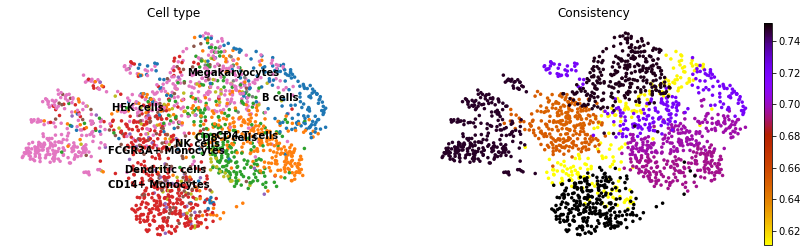

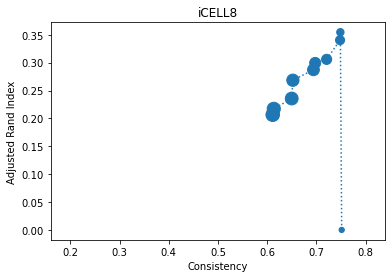

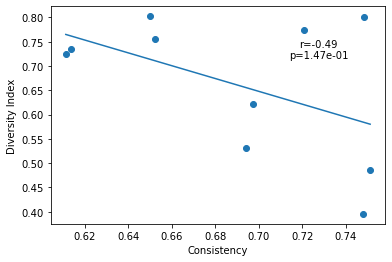

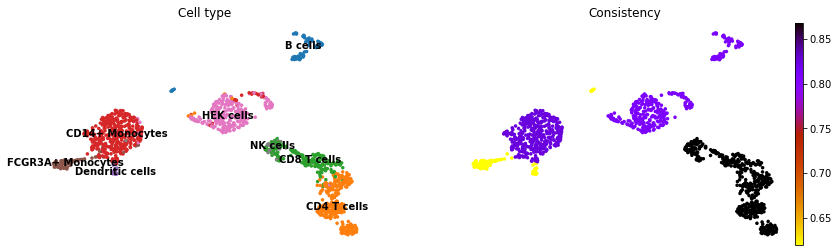

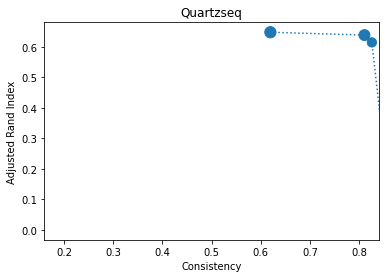

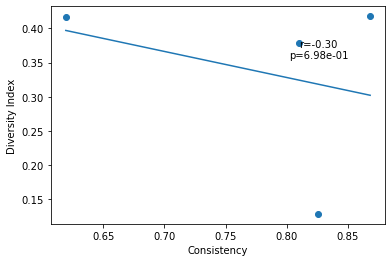

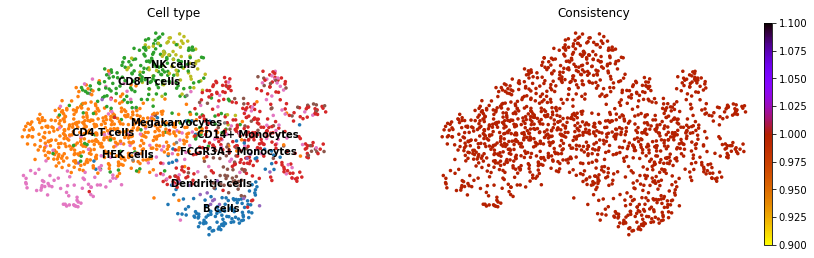

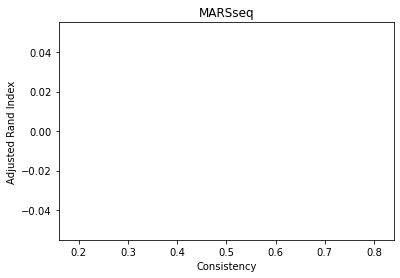

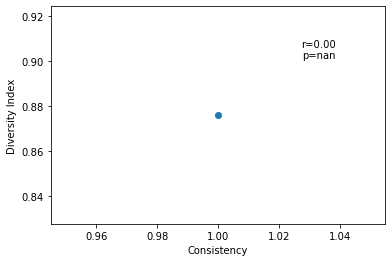

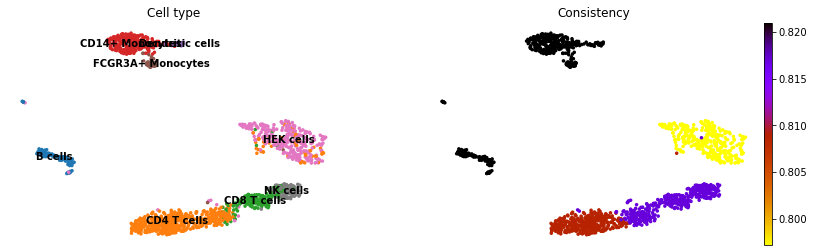

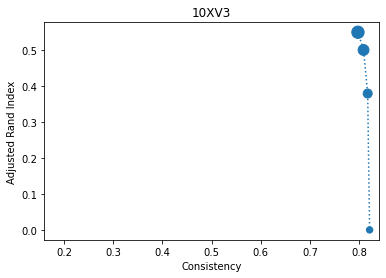

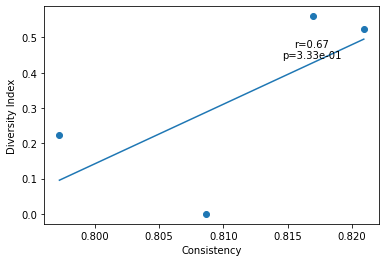

In [28]:
import sklearn.metrics
technology = ['iCELL8', 'Quartzseq', 'MARSseq', '10XV3']
# don't need here to load the .pkl, everything is stored in the .h5ad file
for tech in technology:
    adata = sc.read(f'{tech}.h5ad')
    level = 3#np.argmax(adata.uns['schist']['stats']['modularity'])
    
    schist.tl.cluster_consistency(adata, level=level)
    
    # We will add a function to calculate this, for the time being
    # calculate in a explicit way
    
    E = pd.DataFrame(adata.obs.groupby(f'nsbm_level_{level}')['cluster_consistency'].apply(mean))
#    E = pd.DataFrame(scipy.stats.entropy(adata.obsm[f'CA_nsbm_level_{level}'], axis=0)/ np.log(adata.shape[0]))
#    E.index=adata.obs[f'nsbm_level_{level}'].cat.categories
#    idx = E.sort_values(0).index

#    g = adata.obs[f'nsbm_level_{level}'].values
#    ev = np.ones(len(g))
#    for x in range(len(g)):
#        ev[x] = E.loc[g[x]]
#    adata.obs['consistency'] = ev

    sc.pl.umap(adata, color=['nnet2', 'cluster_consistency'], size=50, legend_loc='on data', color_map='gnuplot_r',
          title=['Cell type',  'Consistency'], frameon=False)

    # calculate Adjusted Rand Index at different thresholds
    ari = []
    n_cells = []
    x_thr = np.unique(adata.obs['cluster_consistency'])

    for thr in x_thr:
        mask = adata.obs['cluster_consistency'] >= thr
        fdata = adata[mask]
        ari.append(sklearn.metrics.adjusted_rand_score(fdata.obs['nnet2'], fdata.obs[f'nsbm_level_{level}']))
        n_cells.append(fdata.shape[0])
    scatter(x_thr, ari, s=np.array(n_cells) / 10)
    plot(x_thr, ari, linestyle=":")
    xlabel('Consistency')
    ylabel("Adjusted Rand Index")
    title(f'{tech}')
    xlim(0.16, .84)
    
    # also plot the consistency versus diversity in each cluster
    E[1] =  scipy.stats.entropy(pd.crosstab(adata.obs['nnet2'], adata.obs[f'nsbm_level_{level}'], normalize='columns'), axis=0) / np.log(8)
    E.columns = ['Consistency', 'Diversity']
    lr = scipy.stats.linregress(E.Consistency, E.Diversity)
    f = figure()
    ax = f.add_subplot(111)
    scatter(E.Consistency, E.Diversity)
    plot(x_thr, lr[0] * x_thr + lr[1])
    xlabel("Consistency")
    ylabel("Diversity Index")
    text(.8, .8,f'r={lr[2]:.2f}\np={lr[3]:.2e}',
     horizontalalignment='center',
     verticalalignment='center',
     transform = ax.transAxes)




## Cell stability

Here, instead, we calculate the stability index for each cell

In [29]:
stabilities = []
for tech in technology:
    adata = sc.read(f'{tech}.h5ad')
    schist.tl.cell_stability(adata)
    stabilities.append(adata.obs['cell_stability'].values)


Show the proportion of stable cells for each technology.

In [30]:
for x in range(len(technology)):
    print(technology[x], (np.sum(stabilities[x] > .95)/len(stabilities[x])))

iCELL8 0.760655737704918
Quartzseq 0.8222748815165877
MARSseq 0.7880085653104925
10XV3 0.7898883782009193
